Occupancy Detection based on ECO dataset: Summer
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [7]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()


In [12]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/02_sm_csv/02"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [13]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

244

In [39]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/02_occupancy_csv/02_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

83

In [40]:
import datetime
summer = df2.index.tolist()
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
    
len(df_summer)
#df_summer["20120730"]

81

In [43]:
notMatched = []
if len(df2)!=len(df_summer):
    for key in summer:
        if key not in df.keys():
            print('.....',key)
            notMatched.append(key)
for i in notMatched:
    df2 = df2.drop(i)
len(df2)

..... 20120530
..... 20120531


81

In [16]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,15.516,20.578,0.0,36.503,832.803,21.656,0.0,854.106,43.559500,21.210507,...,0.754267,0.0,0.0,0.0,0.0,817.287,1.078,0.0,817.603,1.0
25,32.611,20.639,0.0,53.395,265.813,23.053,0.0,286.848,110.233681,21.173459,...,0.981987,0.0,0.0,0.0,0.0,233.202,2.414,0.0,233.453,2.0
26,31.389,20.955,0.0,52.750,473.187,23.340,0.0,494.494,113.426983,21.704437,...,0.941371,0.0,0.0,0.0,0.0,441.798,2.385,0.0,441.744,3.0
27,-1.000,-1.000,-1.0,-1.000,138.668,22.051,0.0,160.207,49.855106,19.000486,...,0.994468,0.0,0.0,0.0,0.0,139.668,23.051,1.0,161.207,4.0
28,-1.000,-1.000,-1.0,-1.000,2451.310,22.253,0.0,2473.120,697.159696,20.794737,...,0.997212,0.0,0.0,0.0,0.0,2452.310,23.253,1.0,2474.120,5.0
29,150.358,21.195,0.0,171.918,2862.930,22.291,0.0,2885.220,1638.093820,21.727387,...,0.998171,0.0,0.0,0.0,0.0,2712.572,1.096,0.0,2713.302,6.0
30,185.754,21.190,0.0,224.319,273.818,232.723,0.0,500.956,220.896894,199.303889,...,0.996116,0.0,0.0,0.0,0.0,88.064,211.533,0.0,276.637,7.0
31,185.346,228.130,0.0,417.617,1181.700,233.193,0.0,1413.170,274.467724,231.782252,...,0.825843,0.0,0.0,0.0,0.0,996.354,5.063,0.0,995.553,8.0
32,187.412,228.281,0.0,419.419,1095.450,232.761,0.0,1326.940,241.234879,231.436752,...,0.840576,0.0,0.0,0.0,0.0,908.038,4.480,0.0,907.521,9.0
33,78.199,229.269,0.0,309.087,262.908,232.422,0.0,494.210,214.340757,231.412500,...,0.995042,0.0,0.0,0.0,0.0,184.709,3.153,0.0,185.123,10.0


In [45]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
  
    

In [47]:
print(occ_summer_data.shape)

(5265, 1)


Replacing all the 'nan' values by '0'

In [48]:
summer_features[np.isnan(summer_features)] = 0

Model with Manual Validation:
-----------

In [49]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [50]:
X = np.array(summer_features)
print('X dim: ',X.shape)
y = np.array(occ_summer_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (5265, 33)
y dim:  (5265, 1)
X_train dim:  (4475, 33, 1)
X_tesy dim:  (790, 33, 1)
y_train dim:  (4475, 1)
y_tesy dim:  (790, 1)


In [51]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0829 11:47:35.516263   388 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 11:47:35.531864   388 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 11:47:35.531864   388 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 11:47:35.620468   388 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0829 11:47:35.637469   388 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 4475 samples, validate on 790 samples
Epoch 1/150
 - 7s - loss: 0.4068 - acc: 0.8333 - val_loss: 0.3620 - val_acc: 0.8646
Epoch 2/150
 - 5s - loss: 0.3315 - acc: 0.8746 - val_loss: 0.3344 - val_acc: 0.8823
Epoch 3/150
 - 5s - loss: 0.2966 - acc: 0.8809 - val_loss: 0.2824 - val_acc: 0.8861
Epoch 4/150
 - 5s - loss: 0.2853 - acc: 0.8887 - val_loss: 0.2997 - val_acc: 0.8835
Epoch 5/150
 - 5s - loss: 0.2762 - acc: 0.8916 - val_loss: 0.2843 - val_acc: 0.9038
Epoch 6/150
 - 5s - loss: 0.2768 - acc: 0.8901 - val_loss: 0.2725 - val_acc: 0.9013
Epoch 7/150
 - 5s - loss: 0.2623 - acc: 0.8990 - val_loss: 0.2760 - val_acc: 0.8911
Epoch 8/150
 - 5s - loss: 0.2591 - acc: 0.9012 - val_loss: 0.2888 - val_acc: 0.8962
Epoch 9/150
 - 5s - loss: 0.2593 - acc: 0.8947 - val_loss: 0.2888 - val_acc: 0.8987
Epoch 10/150
 - 5s - loss: 0.2504 - acc: 0.9010 - val_loss: 0.3108 - val_acc: 0.8911
Epoch 11/150
 - 5s - loss: 0.2506 - acc: 0.9037 - val_loss: 0.2504 - val_acc: 0.9063
Epoch 12/150
 - 5s - loss: 

Epoch 97/150
 - 5s - loss: 0.1666 - acc: 0.9356 - val_loss: 0.2356 - val_acc: 0.9253
Epoch 98/150
 - 5s - loss: 0.1730 - acc: 0.9341 - val_loss: 0.2556 - val_acc: 0.9038
Epoch 99/150
 - 5s - loss: 0.1693 - acc: 0.9368 - val_loss: 0.2314 - val_acc: 0.9215
Epoch 100/150
 - 5s - loss: 0.1629 - acc: 0.9399 - val_loss: 0.2335 - val_acc: 0.9253
Epoch 101/150
 - 5s - loss: 0.1661 - acc: 0.9347 - val_loss: 0.2604 - val_acc: 0.9165
Epoch 102/150
 - 5s - loss: 0.1649 - acc: 0.9341 - val_loss: 0.2317 - val_acc: 0.9228
Epoch 103/150
 - 5s - loss: 0.1663 - acc: 0.9361 - val_loss: 0.2274 - val_acc: 0.9165
Epoch 104/150
 - 5s - loss: 0.1716 - acc: 0.9339 - val_loss: 0.2452 - val_acc: 0.9177
Epoch 105/150
 - 5s - loss: 0.1602 - acc: 0.9408 - val_loss: 0.2486 - val_acc: 0.9114
Epoch 106/150
 - 5s - loss: 0.1648 - acc: 0.9370 - val_loss: 0.2668 - val_acc: 0.9076
Epoch 107/150
 - 5s - loss: 0.1671 - acc: 0.9352 - val_loss: 0.2467 - val_acc: 0.9215
Epoch 108/150
 - 5s - loss: 0.1663 - acc: 0.9354 - val_lo

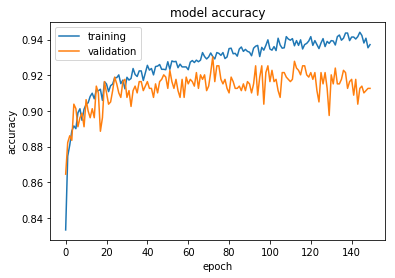

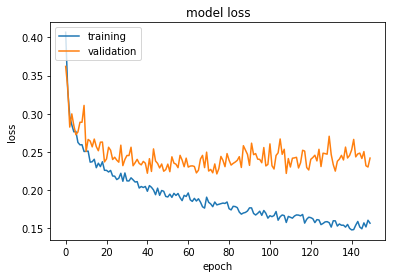

In [52]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

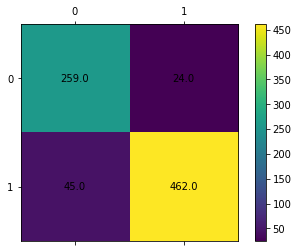

In [53]:
conf_matrix(X_test,y_test,model)

Classification error: 84.78

Early Stopping:
------

In [54]:
model = init_model(features)

Training and Testing:


Train on 4475 samples, validate on 790 samples
Epoch 1/150
 - 7s - loss: 0.4183 - acc: 0.8237 - val_loss: 0.3290 - val_acc: 0.8747
Epoch 2/150
 - 5s - loss: 0.3132 - acc: 0.8780 - val_loss: 0.3545 - val_acc: 0.8595
Epoch 3/150
 - 5s - loss: 0.2931 - acc: 0.8889 - val_loss: 0.2745 - val_acc: 0.8899
Epoch 4/150
 - 5s - loss: 0.2782 - acc: 0.8898 - val_loss: 0.2862 - val_acc: 0.8949
Epoch 5/150
 - 5s - loss: 0.2731 - acc: 0.8936 - val_loss: 0.2905 - val_acc: 0.9038
Epoch 6/150
 - 5s - loss: 0.2649 - acc: 0.8970 - val_loss: 0.2857 - val_acc: 0.8975
Epoch 7/150
 - 5s - loss: 0.2569 - acc: 0.8981 - val_loss: 0.2884 - val_acc: 0.8747
Epoch 8/150
 - 5s - loss: 0.2583 - acc: 0.8952 - val_loss: 0.2867 - val_acc: 0.8861
Epoch 9/150
 - 5s - loss: 0.2568 - acc: 0.9001 - val_loss: 0.2626 - val_acc: 0.8987
Epoch 10/150
 - 5s - loss: 0.2455 - acc: 0.9064 - val_loss: 0.2646 - val_acc: 0.8962
Epoch 11/150
 - 5s - loss: 0.2400 - acc: 0.9050 - val_loss: 0.2762 - val_acc: 0.8949
Epoch 12/150
 - 5s - loss: 

Epoch 97/150
 - 5s - loss: 0.1652 - acc: 0.9359 - val_loss: 0.2351 - val_acc: 0.9152
Epoch 98/150
 - 5s - loss: 0.1696 - acc: 0.9327 - val_loss: 0.2274 - val_acc: 0.9089
Epoch 99/150
 - 5s - loss: 0.1682 - acc: 0.9336 - val_loss: 0.2356 - val_acc: 0.9139
Epoch 100/150
 - 5s - loss: 0.1639 - acc: 0.9368 - val_loss: 0.2333 - val_acc: 0.9177
Epoch 101/150
 - 5s - loss: 0.1683 - acc: 0.9372 - val_loss: 0.2604 - val_acc: 0.9089
Epoch 102/150
 - 5s - loss: 0.1664 - acc: 0.9399 - val_loss: 0.2539 - val_acc: 0.9127
Epoch 103/150
 - 5s - loss: 0.1687 - acc: 0.9363 - val_loss: 0.2454 - val_acc: 0.9152
Epoch 104/150
 - 5s - loss: 0.1668 - acc: 0.9334 - val_loss: 0.2491 - val_acc: 0.9165
Epoch 105/150
 - 5s - loss: 0.1665 - acc: 0.9323 - val_loss: 0.2708 - val_acc: 0.9101
Epoch 00105: early stopping
790/790 [==============================] - 0s 272us/step
loss and accuracy::  [0.27076407372951505, 0.9101265830329702]


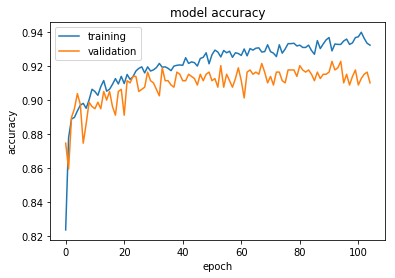

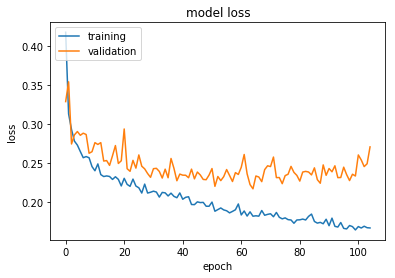

In [55]:
history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history,es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

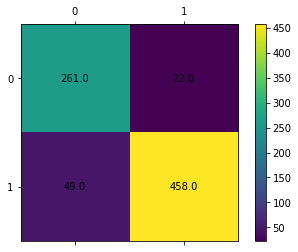

In [56]:
conf_matrix(X_test,y_test,model)

Model with K-fold Validation:
----------

acc: 93.09%


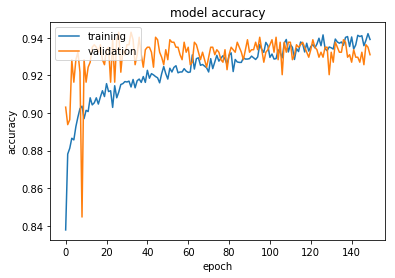

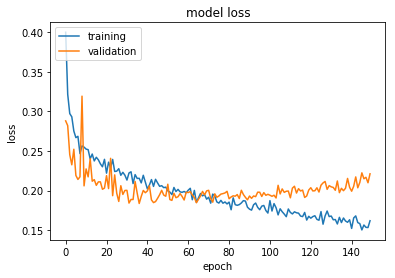

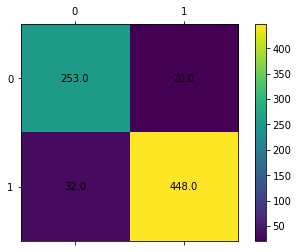

acc: 91.76%


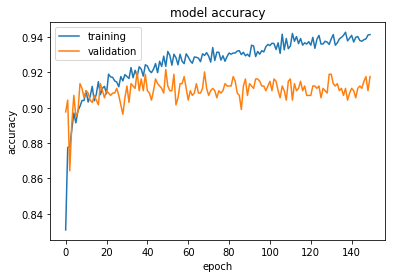

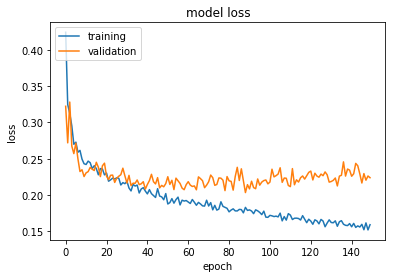

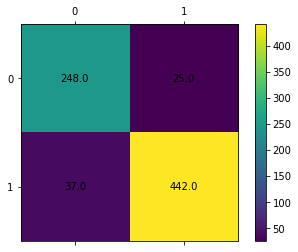

acc: 90.43%


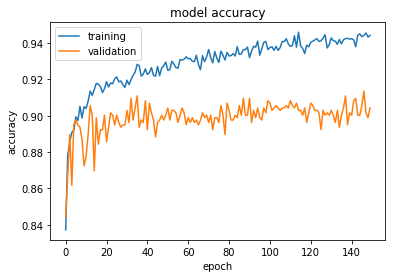

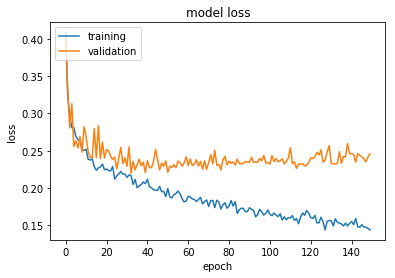

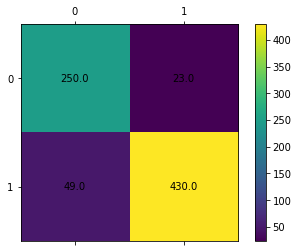

acc: 92.82%


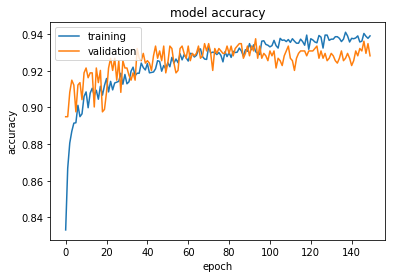

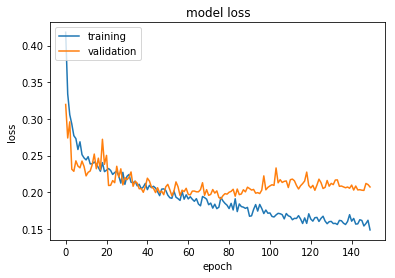

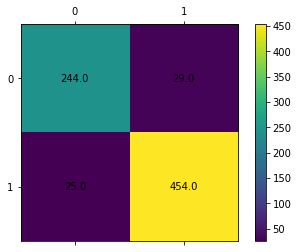

acc: 93.22%


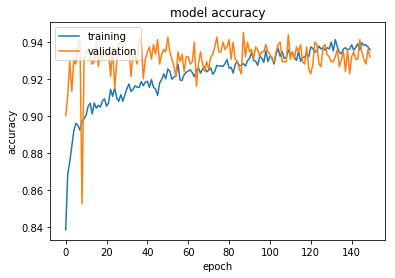

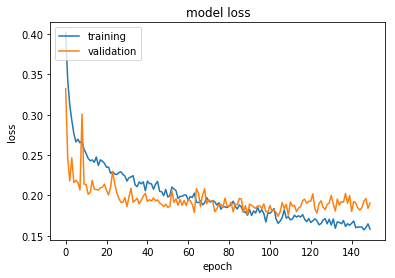

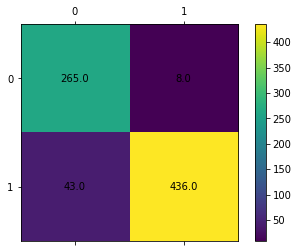

acc: 92.55%


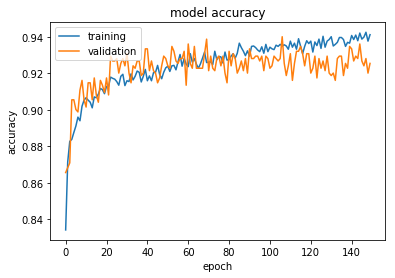

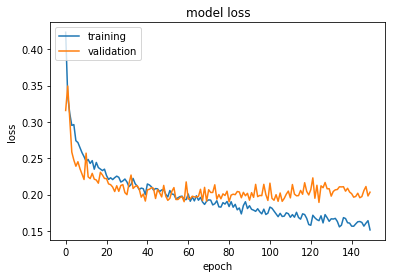

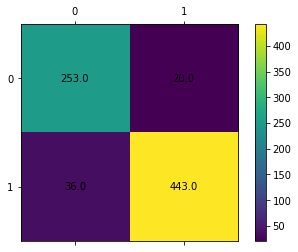

acc: 92.42%


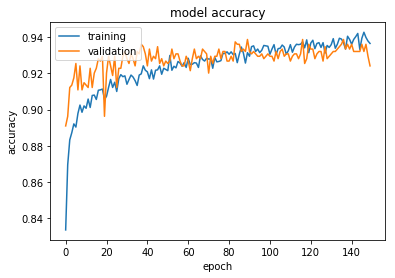

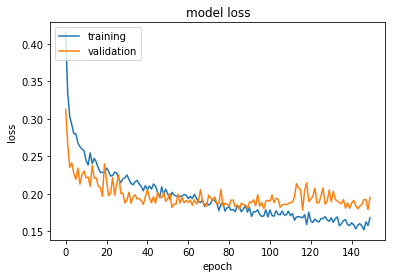

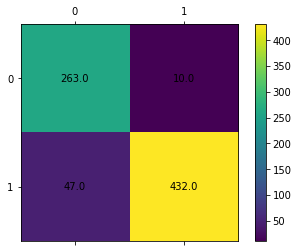

In [58]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history = LossHistory()
    hiss = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    loss.append(scores[0])
#     print(score)
    plt.plot(hiss.history['acc'])
    plt.plot(hiss.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss.history['loss'])
    plt.plot(hiss.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test],model)


In [59]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  92.33% (+/- 0.90%)
error:: 0.21 (+/- 0.02)


Shapely Values:
-------

In [60]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(4475, 33, 1)

In [61]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [62]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(4475, 33)

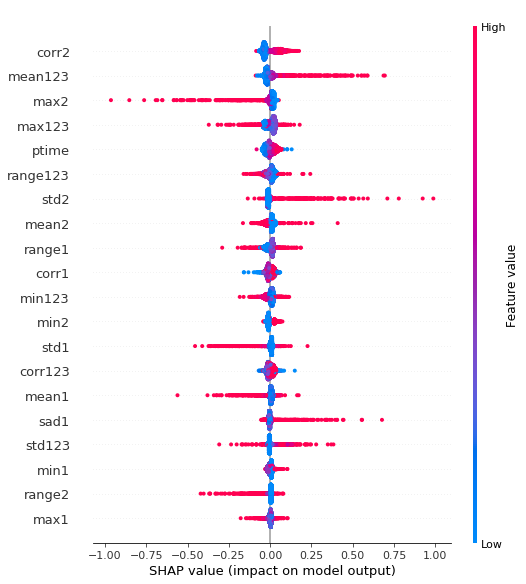

In [63]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

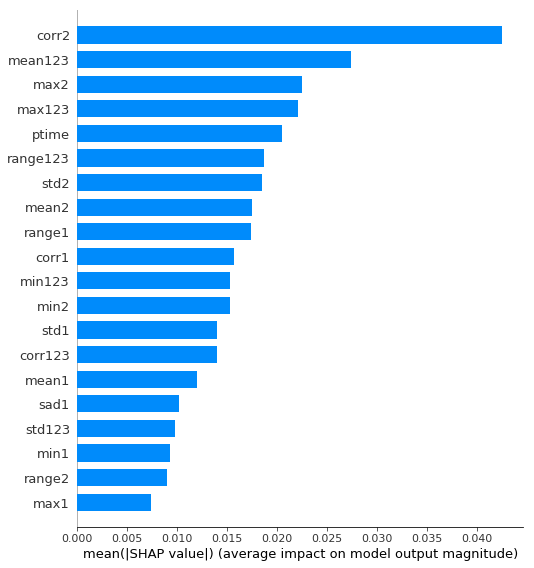

In [64]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

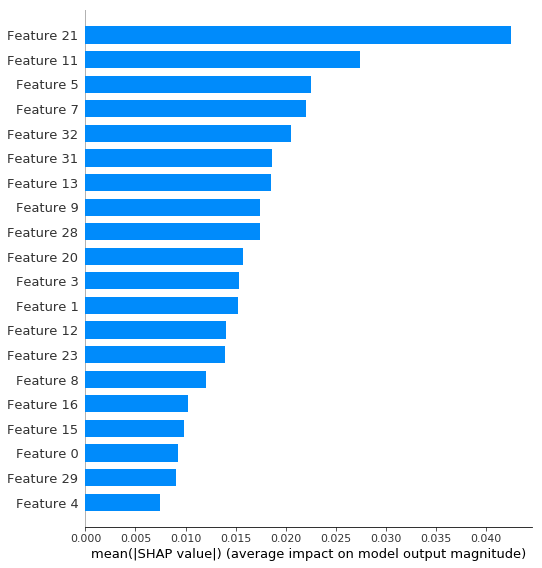

In [65]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [73]:
new_summer_features = np.concatenate((X[:,0:2],X[:,3:6],X[:,7:10], X[:,11:14],X[:,15:17],X[:,20:22],X[:,23][:, np.newaxis],X[:,28:30],X[:,31:33]),axis=1)
new_summer_features.shape

(5265, 20)

In [74]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_summer_features, y, test_size=0.15, shuffle=True)

X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1], 1)
X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

print('X_train dim: ', X_train_s.shape)
print('X_tesy dim: ', X_test_s.shape)
print('y_train dim: ', y_train_s.shape)
print('y_tesy dim: ', y_test_s.shape)

X_train dim:  (4475, 20, 1)
X_tesy dim:  (790, 20, 1)
y_train dim:  (4475, 1)
y_tesy dim:  (790, 1)


In [75]:
features_s = 20
model = init_model(features_s)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_91 (Batc (None, 20, 256)           1024      
_________________________________________________________________
dropout_91 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_92 (Batc (None, 20, 128)           512       
_________________________________________________________________
dropout_92 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 20, 64)            32832     
__________

Early Stopping:
------

In [76]:
model = init_model(features_s)

Training and Testing:


Train on 4475 samples, validate on 790 samples
Epoch 1/150
 - 22s - loss: 0.4063 - acc: 0.8340 - val_loss: 0.3555 - val_acc: 0.8722
Epoch 2/150
 - 10s - loss: 0.3334 - acc: 0.8726 - val_loss: 0.3259 - val_acc: 0.8823
Epoch 3/150
 - 10s - loss: 0.3008 - acc: 0.8842 - val_loss: 0.2668 - val_acc: 0.9038
Epoch 4/150
 - 10s - loss: 0.3018 - acc: 0.8834 - val_loss: 0.3044 - val_acc: 0.8785
Epoch 5/150
 - 10s - loss: 0.2886 - acc: 0.8918 - val_loss: 0.2624 - val_acc: 0.9025
Epoch 6/150
 - 10s - loss: 0.2781 - acc: 0.8923 - val_loss: 0.2599 - val_acc: 0.9101
Epoch 7/150
 - 10s - loss: 0.2616 - acc: 0.8959 - val_loss: 0.2335 - val_acc: 0.9127
Epoch 8/150
 - 10s - loss: 0.2601 - acc: 0.8970 - val_loss: 0.2274 - val_acc: 0.9215
Epoch 9/150
 - 10s - loss: 0.2507 - acc: 0.9023 - val_loss: 0.2398 - val_acc: 0.9241
Epoch 10/150
 - 10s - loss: 0.2520 - acc: 0.8992 - val_loss: 0.2250 - val_acc: 0.9190
Epoch 11/150
 - 10s - loss: 0.2491 - acc: 0.8997 - val_loss: 0.2306 - val_acc: 0.9266
Epoch 12/150
 - 

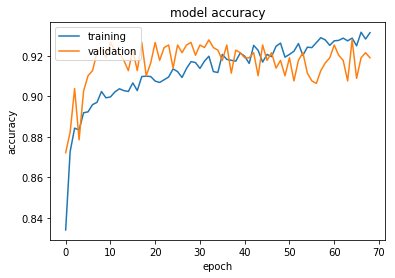

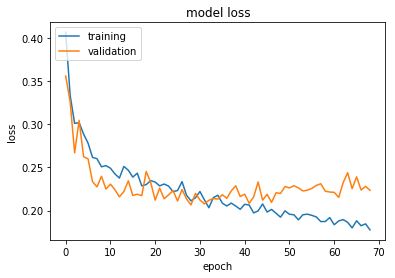

In [77]:
history_se = LossHistory()
es_se = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_se = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history,es_se],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_se = model.evaluate(X_test_s, y_test_s, batch_size=32)
print('loss and accuracy:: ',score_se)

plt.plot(hiss_se.history['acc'])
plt.plot(hiss_se.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_se.history['loss'])
plt.plot(hiss_se.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

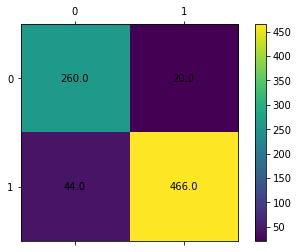

In [78]:
conf_matrix(X_test_s,y_test_s,model)

Model with K-fold Validation:
----------

Epoch 00090: early stopping
acc: 94.02%


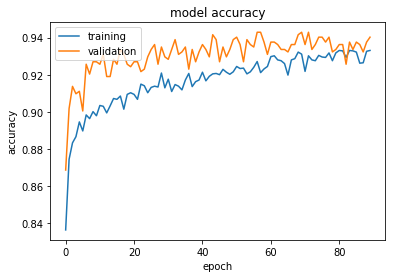

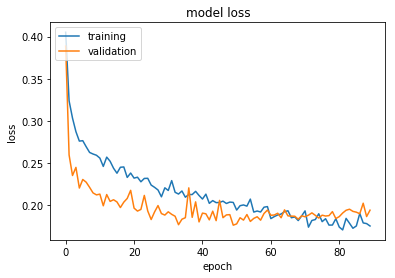

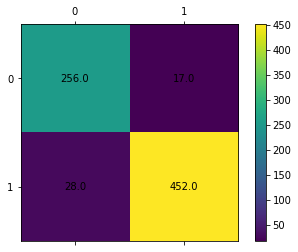

Epoch 00116: early stopping
acc: 91.09%


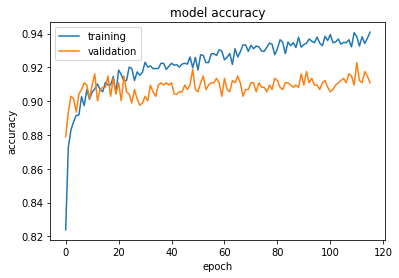

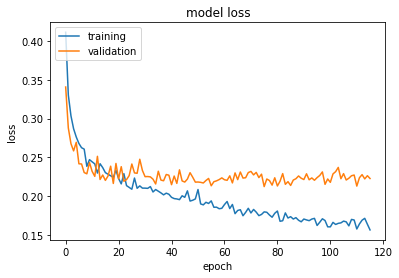

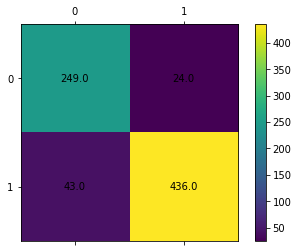

Epoch 00113: early stopping
acc: 90.56%


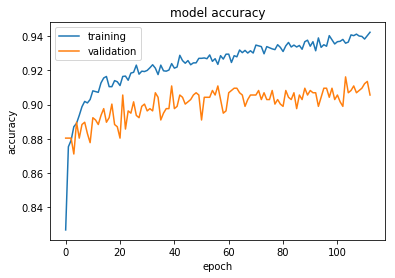

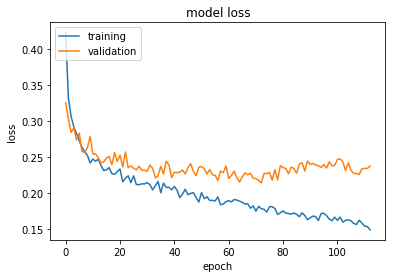

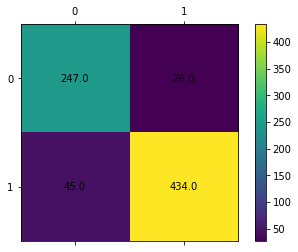

Epoch 00094: early stopping
acc: 92.95%


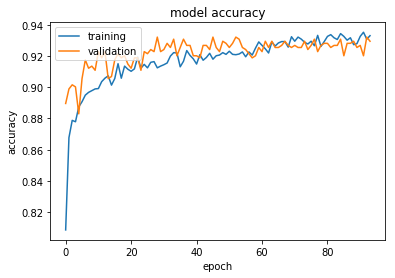

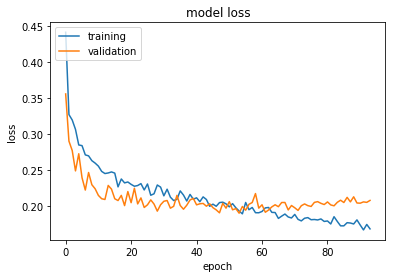

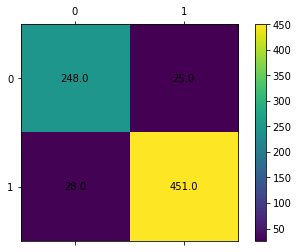

Epoch 00120: early stopping
acc: 93.75%


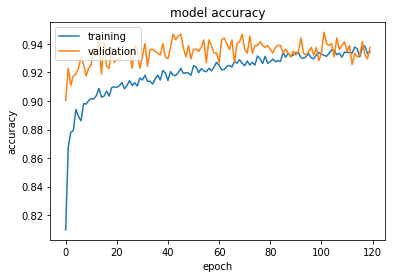

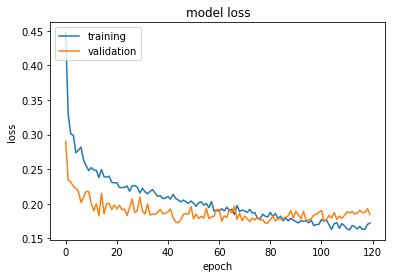

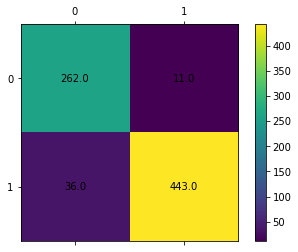

acc: 91.76%


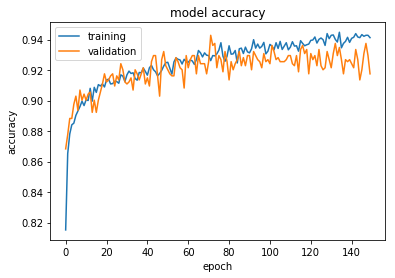

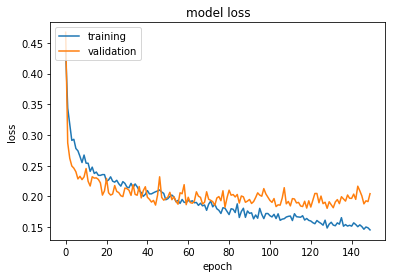

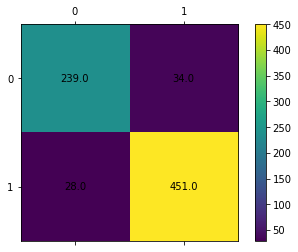

acc: 93.09%


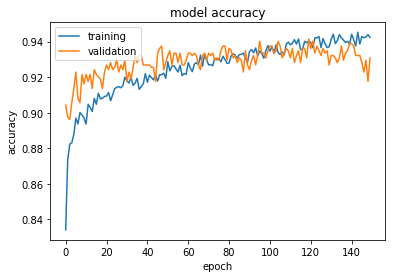

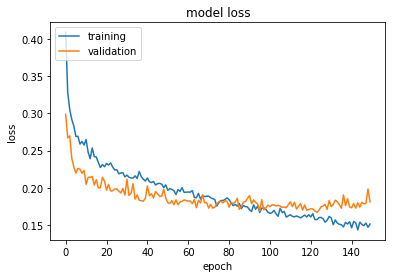

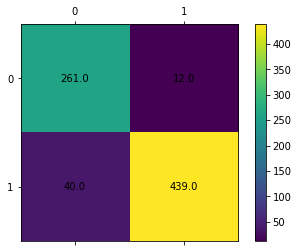

In [79]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_s = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_s = []
loss_s = []
XX = new_summer_features
for train, test in kfold_s.split(XX, y):
    
    model = init_model(features_s)
    
    X_train_ks =XX[train].reshape(XX[train].shape[0], XX[train].shape[1], 1)
    X_test_ks = XX[test].reshape(XX[test].shape[0], XX[test].shape[1], 1)
    history_ks = LossHistory()
    es_ks = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_ks = model.fit(X_train_ks, y[train], epochs=150, batch_size=32,
                callbacks=[history_ks,es_ks],
                validation_data=(X_test_ks,y[test]), verbose=0)
    scores_ks = model.evaluate(X_test_ks, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_ks[1]*100))
    cvscores_s.append(scores_ks[1] * 100)
    loss_s.append(scores_ks[0])
#     print(score)
    plt.plot(hiss_ks.history['acc'])
    plt.plot(hiss_ks.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_ks.history['loss'])
    plt.plot(hiss_ks.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_ks,y[test],model)


In [80]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_s), np.std(cvscores_s)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_s), np.std(loss_s)))

accuracy::  92.46% (+/- 1.24%)
error:: 0.20 (+/- 0.02)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XX[train]
    X_test = XX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


PCA:
-------

In [81]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [82]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [83]:
pca.n_components_

13

In [84]:
summer_pca = pca.transform(X)

In [92]:
summer_pca.shape

(5265, 13)

In [93]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(summer_pca, y, test_size=0.15, shuffle=True)

In [94]:
X_train_p.shape

(4475, 13)

Early Stopping:
------

In [88]:
features_p = X_train_p.shape[1]
model = init_model(features_p)

X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], 1)
X_test_p = X_test_p.reshape(X_test_p.shape[0], X_test_p.shape[1], 1)

print('X_train dim: ', X_train_p.shape)
print('X_tesy dim: ', X_test_p.shape)
print('y_train dim: ', y_train_p.shape)
print('y_tesy dim: ', y_test_p.shape)

X_train dim:  (4475, 13, 1)
X_tesy dim:  (790, 13, 1)
y_train dim:  (4475, 1)
y_tesy dim:  (790, 1)


Training and Testing:


Train on 4475 samples, validate on 790 samples
Epoch 1/150
 - 24s - loss: 0.4380 - acc: 0.8177 - val_loss: 0.3001 - val_acc: 0.8823
Epoch 2/150
 - 8s - loss: 0.3539 - acc: 0.8621 - val_loss: 0.2974 - val_acc: 0.8886
Epoch 3/150
 - 9s - loss: 0.3212 - acc: 0.8742 - val_loss: 0.2658 - val_acc: 0.8873
Epoch 4/150
 - 8s - loss: 0.3043 - acc: 0.8811 - val_loss: 0.2494 - val_acc: 0.9025
Epoch 5/150
 - 8s - loss: 0.3015 - acc: 0.8818 - val_loss: 0.2392 - val_acc: 0.9076
Epoch 6/150
 - 8s - loss: 0.2840 - acc: 0.8898 - val_loss: 0.2567 - val_acc: 0.8975
Epoch 7/150
 - 8s - loss: 0.2869 - acc: 0.8825 - val_loss: 0.2505 - val_acc: 0.8987
Epoch 8/150
 - 8s - loss: 0.2792 - acc: 0.8894 - val_loss: 0.2437 - val_acc: 0.9038
Epoch 9/150
 - 8s - loss: 0.2792 - acc: 0.8896 - val_loss: 0.2319 - val_acc: 0.9101
Epoch 10/150
 - 8s - loss: 0.2581 - acc: 0.8983 - val_loss: 0.2509 - val_acc: 0.9051
Epoch 11/150
 - 9s - loss: 0.2604 - acc: 0.8945 - val_loss: 0.2226 - val_acc: 0.9165
Epoch 12/150
 - 9s - loss:

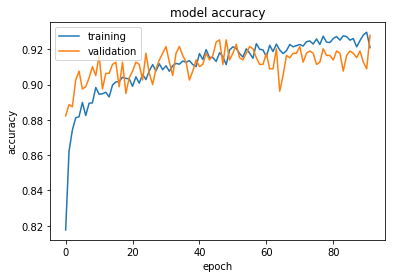

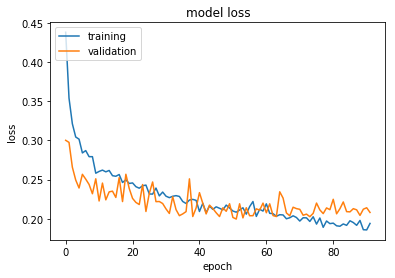

In [89]:
history_pe = LossHistory()
es_pe = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pe = model.fit(X_train_p, y_train_p, epochs=150, batch_size=32,
                callbacks=[history_pe,es_pe],
                validation_data=(X_test_p,y_test_p), verbose=2)
score_pe = model.evaluate(X_test_p, y_test_p, batch_size=32)
print('loss and accuracy:: ',score_pe)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

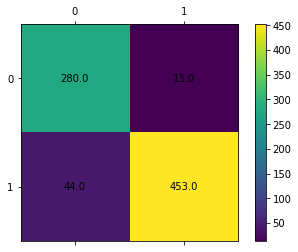

In [90]:
conf_matrix(X_test_p,y_test_p,model)

Model with K-fold Validation:
----------

Epoch 00146: early stopping
acc: 93.09%


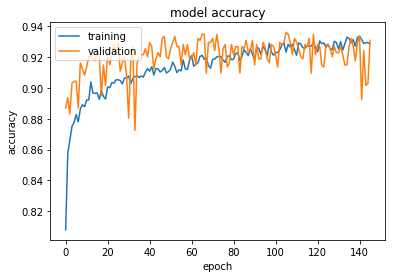

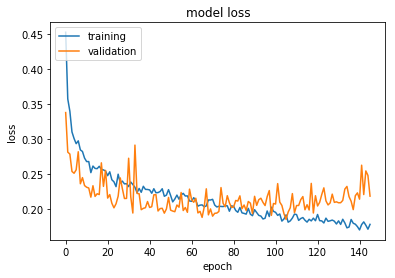

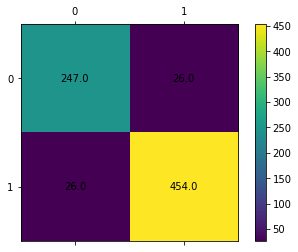

Epoch 00090: early stopping
acc: 91.76%


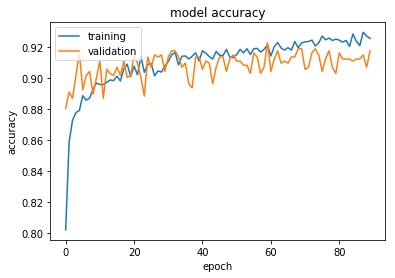

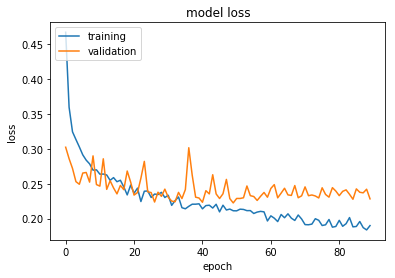

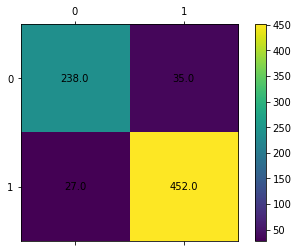

Epoch 00091: early stopping
acc: 90.03%


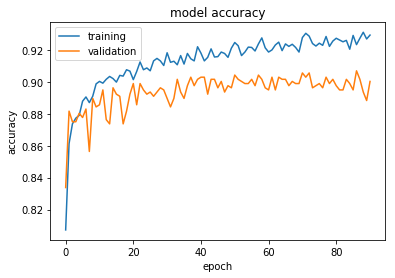

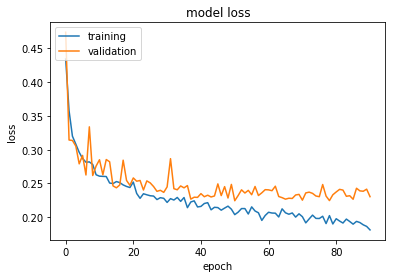

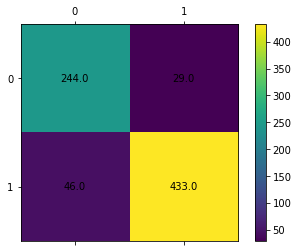

Epoch 00122: early stopping
acc: 92.29%


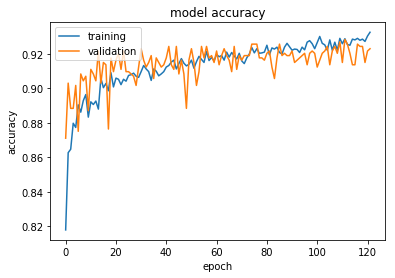

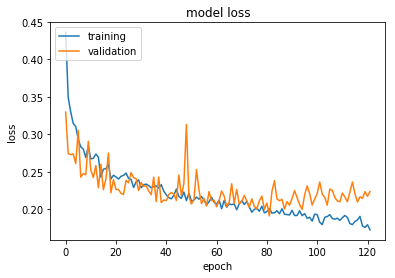

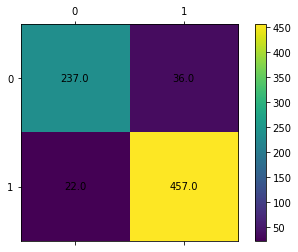

Epoch 00115: early stopping
acc: 93.62%


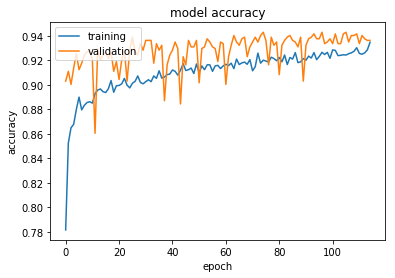

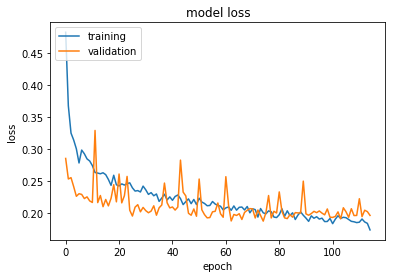

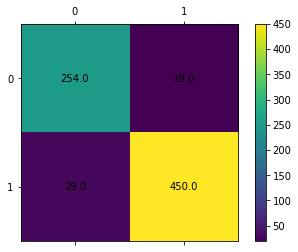

Epoch 00134: early stopping
acc: 90.56%


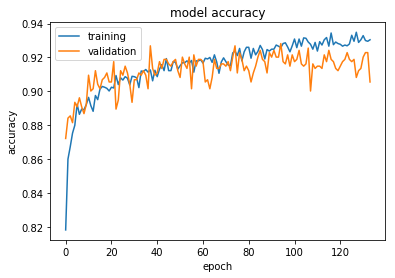

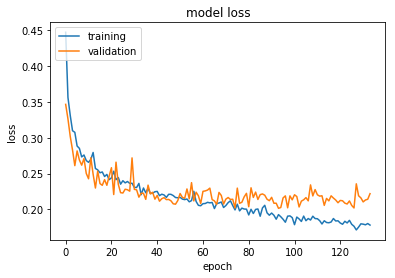

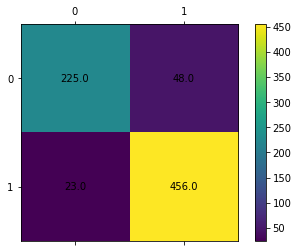

Epoch 00132: early stopping
acc: 92.55%


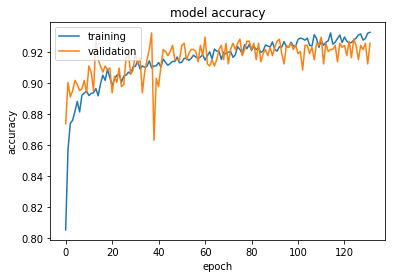

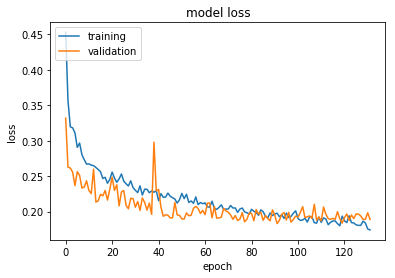

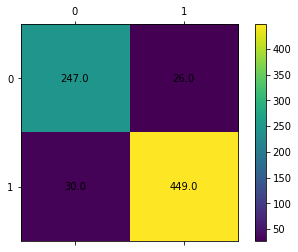

In [95]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
XXX = summer_pca
for train, test in kfold_s.split(XXX, y):
    
    model = init_model(features_p)
    
    X_train_kp =XXX[train].reshape(XXX[train].shape[0], XXX[train].shape[1], 1)
    X_test_kp = XXX[test].reshape(XXX[test].shape[0], XXX[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)


In [96]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_p), np.std(cvscores_p)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_p), np.std(loss_p)))

accuracy::  91.98% (+/- 1.21%)
error:: 0.22 (+/- 0.01)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XXX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XXX[train]
    X_test = XXX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()